Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [CuDF documentation](https://docs.rapids.ai/api/cudf/stable/)
* [cuML documentation](https://docs.rapids.ai/api/cuml/stable/)


# Installing software

In [38]:
# Software to download files
!pip install gdown

In [39]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.14+7-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
mkdir: cannot create directory ‘checkpoint’: File exists


In [40]:
# Install RAPIDS - for using cuDF, cuML
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible,
# it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Audited 11 packages in 145ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [41]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [42]:
!ls "/content/drive/MyDrive/Engineering_of_Data_Analysis"

sample.csv.gz  sorted_data.csv.gz  tiny.csv.gz


Next cells setup: Pandas, Spark and cuDF/cuML.

In [43]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster

In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)

In [45]:
# Imports for cuDF / cuML

import cudf
import cupy as cp
import cuml.cluster

In [46]:
# Setup the dataset being used

# Large dataset - 12.3 GB compressed
#FILENAME = "/content/drive/MyDrive/Engineering_of_Data_Analysis/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
FILENAME = "/content/drive/MyDrive/Engineering_of_Data_Analysis/sample.csv.gz"

# Tiny dataset - 6.8 MB compressed (you can use this one for speeding up development only)
#FILENAME = "/content/drive/MyDrive/Engineering_of_Data_Analysis/tiny.csv.gz"


## Simple statistics

We will print some simple statistics.

In [47]:
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|        10867|      20354|2013-01-01 00:00:00|2013-01-21 00:11:45|        10800|            95.85|           465.0|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+

Runtime = 23.96291756629944


## Ploting information

Example on how to plot information using matplotlib.

### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups.

Plotting pickups


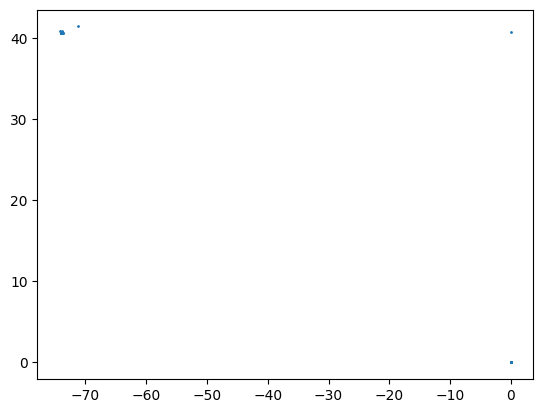

In [48]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()


### Plotting heatamps

This example shows how to **plot heatmaps** and how to **create a grid** with coordinates -- note that we need to group nearby coordinates together or (almost) every coordinate will be unique.

The example creates a grid, with cell of 150m of side (commented out the code for cells of 500m of side).

\[From ACM DEBS 2015 Grand Challenge page\]

**Question 1**: Is the earth flat or how to map coordinates to cells?

**Answer**: For the challenge we allow a simplified flat earth assumption for mapping coordinates to cells in the queries. You can assume that a distance of 500 meter south corresponds to a change of 0.004491556 degrees in the coordinate system. For moving 500 meter east you can assume a change of 0.005986 degrees in the coordinate system.

Plotting pickups


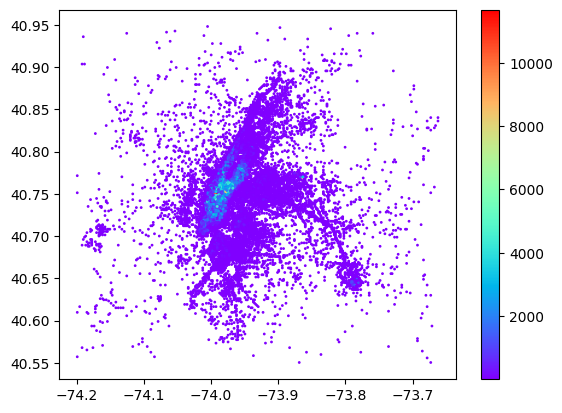

Plotting pickups


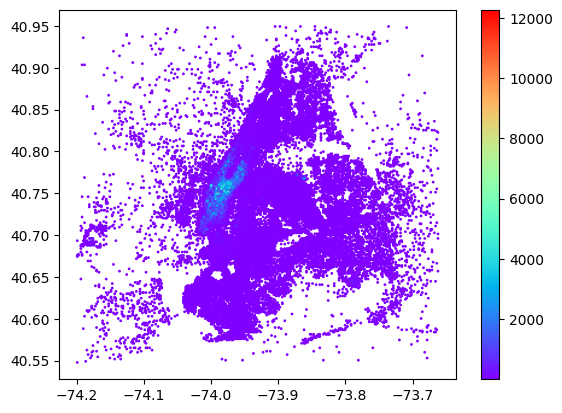

In [49]:
# Squares of 500 meters
#latitudeStep = 0.004491556
#longitudeStep = 0.005986
#northLatitude = 41.474937 - 0.5 * latitudeStep
#southLatitude = northLatitude - 300 * latitudeStep
#eastLongitude = -74.913585 - 0.5 * longitudeStep
#westLongitude = eastLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(westLongitude) + """ AND
                                  pickup_longitude <=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(eastLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Statistics for pickups
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()



## Exercise 1: simple statistics - comparing computation with Pandas, Spark Pandas API, Spark SQL and cuDF

For each license, we compute the total amount of money collected. We then compare the time it takes to execute the code for Pandas, Spark Pandas API, Spark SQL and cuDF.

**We draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the small and long dataset.

### Code: Pandas library

In [50]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()
row_size_bytes = dataset.memory_usage(deep=True).sum() / len(dataset)


end_time = time.time()

print(f"Length of Dataset: {dataset.shape}")
print(f"Each row takes approximately {row_size_bytes:.2f} bytes")
print("Runtime = " + str(end_time - start_time))


Length of Dataset: (1999999, 17)
Each row takes approximately 486.00 bytes
Runtime = 11.196709632873535


### Results (Pandas)

- The time to process the small dataset was : **11.196709632873535** seconds. ✅
- The time to process the large dataset: **DIDN'T COMPLETE** 🛑

### Code: Spark Pandas API

In [51]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = ps.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()
# force execution
result0 = result.to_spark().collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime = 19.750504970550537


### Results (Spark Pandas API)

The time to process the small dataset was : **19.750504970550537** seconds. ✅

The time to process the large dataset was : **DIDN'T COMPLETE** 🛑

### Spark SQL

In [52]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT hack_license, SUM(total_amount) AS total_amount FROM data GROUP BY hack_license""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 8.3165123462677


### Results (Spark)

The time to process the small dataset was : **8.3165123462677** seconds. ✅

The time to process the large dataset was : **776.042863368988** seconds. ✅

### Code: cuDF

In [53]:
import gzip
import shutil

# Decompress to a temporary file
with gzip.open(FILENAME, 'rb') as f_in:
    with open("uncompressed.csv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)




In [54]:
import cuml
import cupy

print("cuML version:", cuml.__version__)
print("GPU check via CuPy:", cupy.cuda.runtime.getDeviceProperties(0)["name"])


cuML version: 25.04.00
GPU check via CuPy: b'Tesla T4'


In [68]:
import pandas as pd
import cudf

start_time = time.time()

mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

chunk_size = 100_000  # You can tune this down if it still OOMs
partial_results = []

for chunk in pd.read_csv("uncompressed.csv", names=mySchema, chunksize=chunk_size):
    # Convert to cuDF for GPU aggregation
    chunk_cudf = cudf.from_pandas(chunk)
    grouped = chunk_cudf[["hack_license", "total_amount"]].groupby("hack_license").sum()
    partial_results.append(grouped)

# Combine and finalize aggregation
result = cudf.concat(partial_results)
final_result = result.groupby("hack_license").sum()


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))
print(final_result.head())


Runtime = 5.701650857925415
                                  total_amount
hack_license                                  
E1BA2677EDAF0A7B1FB02EFAEFBD2513       1873.44
BBB738A4E3184BA6F3F4432142CC3EB4       1677.04
17532BD996A2DE5273D5B1995E7C46D6       1648.62
464F5166E5CD2C8DE9702D9B7B9BC138       2543.42
87C26A11C3E53786D5F91C6A69AB9767         63.30


### Results (cuDF)

The time to process the small dataset was : **5.701650857925415** seconds. ✅

The time to process the large dataset was : **746.5195298194885** seconds. ✅

### Results discussion


#### Process Time Table

| Package          | Small Dataset | Large Dataset         |
|:------------------|:--------------|:------------------------|
| Pandas            | 11.19 sec       | 🚩                      |
| Spark Pandas API  | 19.75 sec      | 🚩                      |
| Spark SQL         | 8.31 sec       | 776.04 sec              |
| cuDF              | 5.70 sec       | 746.52 sec              |

🚩: Computationally Impossible (due to memory limits)

---

#### Pandas

- The small dataset contains approximately 1.99 million rows, with each row consuming around 500 bytes of memory. This amounts to roughly 1 GB of RAM usage, representing just 1.5% of the original dataset’s size.
- By extrapolating from this, we estimate that the full dataset consists of around 132 million rows, which would require approximately 132 million × 500 bytes = 66 GB of RAM to process in-memory (as Pandas is using batch processing)
- Given that Pandas operates entirely in RAM, and the available system memory is only 12 GB, it's clear that processing the full dataset with Pandas on this machine exceeds the system's capacity.
- On small data, Pandas performs reasonably well and is easy to use, but it does not scale.
---
#### Spark Pandas API

- We force the grouped result to be collected into the driver’s memory (RAM). While the groupby and sum operations are distributed across the Spark engine, `.collect()` retrieves all the data to a single node.
- If the result contains millions of unique hack_license values, this collection can easily require several gigabytes of RAM — often exceeding the available memory of a local machine.
- The overhead from integrating Pandas-like syntax into Spark leads to the **slowest runtime on small datasets**, making it the least efficient option in that case.
- Similar to Pandas, it fails on the large dataset due to RAM constraints on the local driver.
---
#### SparkSQL

- Spark SQL reads the CSV file with an explicit schema and performs a `GROUP BY` aggregation using SQL syntax. The computation is distributed across Spark's execution engine, which is optimized for large-scale data processing.
- However, calling `.collect()` at the end forces all results to be brought into the driver’s memory. This introduces overhead due to:
  - Spark job initialization
  - Catalyst optimizer planning
  - JVM ↔ Python communication
  - Data serialization and collection
- On **small datasets**, Spark SQL is faster than Pandas due to parallelism.  
- On **large datasets**, it scales successfully but becomes significantly slower due to the orchestration and memory transfer overhead.
---
#### cuDF

- cuDF loads the dataset into GPU memory and performs the same aggregation using GPU-accelerated groupby operations. Since all processing happens in parallel on the GPU, and no Spark-like orchestration is required, the runtime is significantly lower.
- cuDF avoids Python overhead and executes highly efficient memory-bound operations directly in CUDA, making it **extremely fast for small datasets**.
- On large datasets, **cuDF performs faster than Spark SQL** but is still bound by GPU memory size and I/O limits.
---
#### Summary and Conclusions

- **cuDF is the fastest solution** on the small dataset due to GPU acceleration and minimal overhead.
- **Pandas is simple and performs well on small data**, but cannot handle large datasets due to memory limitations.
- **SparkSQL is scalable**, making it a valid option for large datasets, but is significantly slower than cuDF due to orchestration and collection overhead.
- **Spark Pandas API** performs worst on the small dataset and fails on the large one. It combines the inefficiencies of both Spark and Pandas for this specific aggregation task.
- Overall, **cuDF offers the best performance if the GPU has enough VRAM**; otherwise, **Spark SQL is the most robust option** for large-scale processing in distributed environments.


## Exercise 2 - Python UDF vs Spark SQL

The code presented in the **Plotting heatmap** section includes the call to an registered Python UDF function. In this exercise we want to measure the impact of using the UDF function.

We run this exercise with the small dataset.

In [56]:
start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(westLongitude) + """ AND
                                  pickup_longitude <=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(eastLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 16.390003204345703


**Results (Spark SQL with UDF Python function)**

The time to process the small dataset was : **16.390003204345703** seconds.

Write the code in Spark SQL without using the auxiliary function.

In [57]:
start_time = time.time()

#Initiate
#Use lat / long from Cell above
dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false") #Use mySchema from above

dataset.createOrReplaceTempView("data")

#Creating the Query without the UDF #

query = f"""
SELECT
  medallion, hack_license, pickup_datetime, dropoff_datetime, trip_time_in_secs, trip_distance,
  FLOOR((pickup_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep / 2} AS pickup_longitude,
  FLOOR((dropoff_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep / 2} AS dropoff_longitude,
  {northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep / 2} AS pickup_latitude,
  {northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep / 2} AS dropoff_latitude,
  payment_type, fare_amount, mta_tax, tip_amount, tolls_amount, total_amount
FROM
  data
WHERE
  pickup_longitude >= {westLongitude} AND pickup_longitude <= {eastLongitude} AND
  dropoff_longitude >= {westLongitude} AND dropoff_longitude <= {eastLongitude} AND
  pickup_latitude <= {northLatitude} AND pickup_latitude >= {southLatitude} AND
  dropoff_latitude <= {northLatitude} AND dropoff_latitude >= {southLatitude}
"""


dfwithoutUDF = spark.sql(query)
dfwithoutUDF.createOrReplaceTempView("data")
dfwithoutUDF.show(5)


# Frequency for pickups --> For now stays the same
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                   FROM data
                                   GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))




+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+-----------------+---------------+----------------+------------+-----------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|dropoff_longitude|pickup_latitude|dropoff_latitude|payment_type|fare_amount|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+-----------------+---------------+----------------+------------+-----------+-------+----------+------------+------------+
|07290D3599E7A0D62...|E7750A37CAB07D0DF...|2013-01-01 00:00:00|2013-01-01 00:02:00|              120|         0.44|     -73.9566691|      -73.9620565|  40.7175619770|   40.7148670434|         CSH|        3.5|    0.5|       0.0|         0.

**Results (Spark SQL with no UDF Python function)**

The time to process the small dataset was : **9.708295345306396** seconds.




### Discussion of results

####  Overview of the Two Approaches

| Aspect                     | Code 1: UDF-Based Approach                     | Code 2: SQL-Based Calculation (No UDF)      |
|---------------------------|------------------------------------------------|---------------------------------------------|
| **Method**                | Uses Python UDFs for coordinate rounding       | Calculates directly within the SQL query    |
| **Runtime**               | 16.39 seconds                                   | 9.7 seconds                                  |
| **Performance**           | Slower due to Python-JVM context switching     | Faster due to native execution and Spark optimization |
| **Code Structure**        | Separate Python functions, registered as UDFs  | More compact but with longer SQL expressions |

####  Why is Code 2 faster?

- **UDFs introduce overhead**: Spark has to move data between the JVM (where Spark runs) and the Python process (where your UDF is defined). This slows down execution and disables certain internal optimizations.
- **SQL expressions are optimized**: When computations are done directly in SQL, Spark can optimize them via Catalyst (its internal query optimizer), generate code efficiently, and execute in a single pass.

#### Conclusion

- **Code 2** is significantly more efficient for this use case.
- We should prefer **built-in Spark SQL functions and expressions** over UDFs whenever possible.
- UDFs are only recommended for **very complex logic** that cannot be expressed with native Spark functions.



## Exercise 3 - Planning new express bus routes

Let's start by trying to help the city to identify which new express bus routes shoud introduce. To this end, we find the 20 most frequent routes whose distance is above a given treshold.

For establishing these routes, we use a grid of 500m of side.

We use 2 solutions: one using Spark SQL and the other Spark Pandas API.

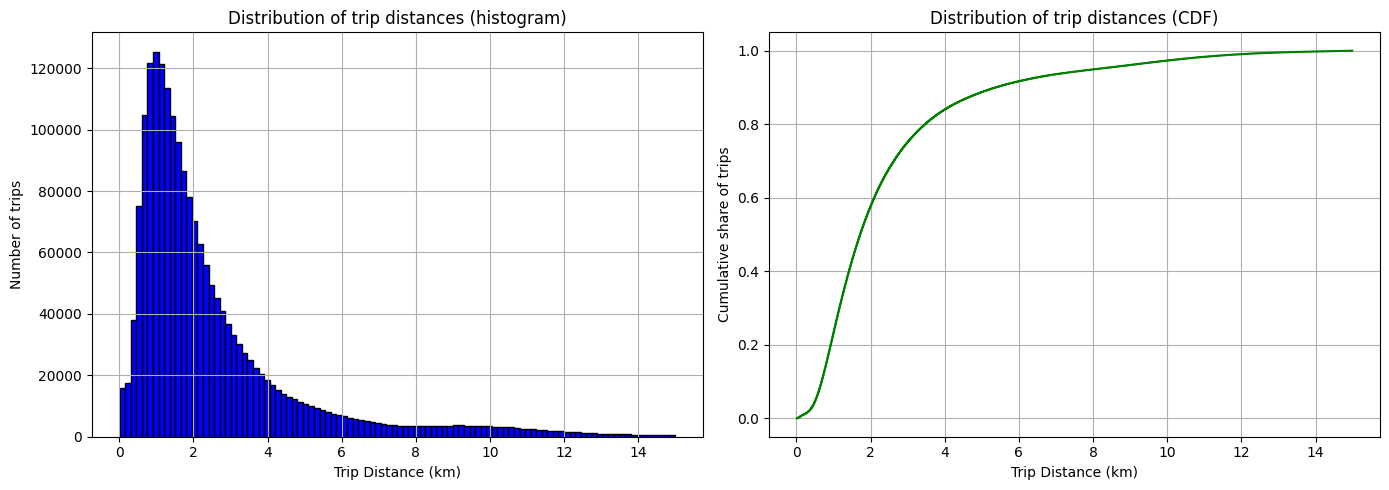

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Trip distances as a list
distances = dataset.select("trip_distance") \
    .where("trip_distance IS NOT NULL AND trip_distance > 0 AND trip_distance < 15") \
    .rdd.flatMap(lambda x: x).collect()

# sort for CDF
sorted_distances = np.sort(distances)
cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)

# Subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axs[0].hist(distances, bins=100, color='blue', edgecolor='black')
axs[0].set_xlabel("Trip Distance (km)")
axs[0].set_ylabel("Number of trips")
axs[0].set_title("Distribution of trip distances (histogram)")
axs[0].grid(True)

# CDF
axs[1].plot(sorted_distances, cdf, color='green')
axs[1].set_xlabel("Trip Distance (km)")
axs[1].set_ylabel("Cumulative share of trips")
axs[1].set_title("Distribution of trip distances (CDF)")
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Selection of the distance threshhold

#### Approach
To identify promising candidates for new express bus routes, we focused on trips that are long enough to benefit from faster public transport. Express buses are only useful for connections where walking or local buses would be significantly slower. To define a meaningful distance threshold, we analyzed the distribution of trip distances in the dataset.

---
#### Graphical analyis

The histogram clearly shows that most trips peak around 1.5 km and drop off sharply beyond 3 km. The cumulative distribution function confirms this, indicating that roughly 75% of all trips are shorter than 3 km. These short distances are typically within neighborhoods and unlikely to justify an express service.

---
### Conclusion
By setting the threshold at **3.0 km**, we exclude very short trips while still capturing a large share of relevant data. This allows us to focus on trips where an express bus could meaningfully reduce travel time and connect distinct areas of the city. The threshold is therefore both functionally appropriate and empirically supported.

In [59]:
# COMPLETE with Spark SQL code

start_time = time.time()

# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 41.474937
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.913585
eastLongitude = westLongitude + 300 * longitudeStep

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false") #Use mySchema from above
dataset.createOrReplaceTempView("data")



DISTANCE_THRESHOLD = 3.0  # km
query = f"""
SELECT
  FLOOR((pickup_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep / 2} AS pickup_x,
  FLOOR((dropoff_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep / 2} AS dropoff_x,
  {northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep / 2} AS pickup_y,
  {northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep / 2} AS dropoff_y,
  COUNT(*) AS trip_count
FROM data
WHERE trip_distance >= {DISTANCE_THRESHOLD}
AND pickup_latitude BETWEEN {southLatitude} AND {northLatitude}
AND pickup_longitude BETWEEN {westLongitude} AND {eastLongitude}
AND dropoff_latitude BETWEEN {southLatitude} AND {northLatitude}
AND dropoff_longitude BETWEEN {westLongitude} AND {eastLongitude}
GROUP BY pickup_x, pickup_y, dropoff_x, dropoff_y
ORDER BY trip_count DESC
LIMIT 20
"""

top_routes_df_sparksql = spark.sql(query)
top_routes_df_sparksql.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+----------+----------+------------+------------+----------+
|  pickup_x| dropoff_x|    pickup_y|   dropoff_y|trip_count|
+----------+----------+------------+------------+----------+
|-73.988748|-73.863042|40.758533818|40.767516930|       329|
|-73.875014|-73.976776|40.772008486|40.749550706|       322|
|-73.952832|-73.988748|40.772008486|40.749550706|       318|
|-73.869028|-73.982762|40.772008486|40.758533818|       314|
|-73.952832|-73.988748|40.776500042|40.749550706|       313|
|-73.875014|-73.982762|40.772008486|40.763025374|       311|
|-73.988748|-73.869028|40.758533818|40.772008486|       311|
|-73.976776|-73.869028|40.763025374|40.772008486|       306|
|-73.976776|-73.863042|40.763025374|40.767516930|       306|
|-73.982762|-73.869028|40.763025374|40.772008486|       305|
|-73.869028|-73.976776|40.772008486|40.749550706|       295|
|-73.875014|-73.982762|40.772008486|40.758533818|       283|
|-73.952832|-73.988748|40.767516930|40.749550706|       279|
|-73.952832|-73.988748|4

In [60]:
# COMPLETE with Spark Pandas API code
import pyspark.pandas as ps

#start_time
start_time = time.time()

#
spark.conf.set("spark.sql.ansi.enabled", "false")

# Convert Spark DataFrame to pandas-on-Spark DataFrame
df = dataset.pandas_api()

# Step size configuration (500m grid)
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 41.474937
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.913585
eastLongitude = westLongitude + 300 * longitudeStep



# Compute grid cell center coordinates for pickup
df["pickup_x"] = ((df["pickup_longitude"] - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
df["pickup_y"] = northLatitude - ((northLatitude - df["pickup_latitude"]) // latitudeStep) * latitudeStep - latitudeStep / 2

# Compute grid cell center coordinates for dropoff
df["dropoff_x"] = ((df["dropoff_longitude"] - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
df["dropoff_y"] = northLatitude - ((northLatitude - df["dropoff_latitude"]) // latitudeStep) * latitudeStep - latitudeStep / 2

# Filter by distance and bounding box
filtered_df = df[
    (df["trip_distance"] >= 3.0) &
    (df["pickup_latitude"].between(southLatitude, northLatitude)) &
    (df["pickup_longitude"].between(westLongitude, eastLongitude)) &
    (df["dropoff_latitude"].between(southLatitude, northLatitude)) &
    (df["dropoff_longitude"].between(westLongitude, eastLongitude))
]

# Group by pickup/dropoff grid cell and count trips
grouped_df = filtered_df.groupby(["pickup_x", "pickup_y", "dropoff_x", "dropoff_y"]) \
    .agg({"trip_distance": "count"}) \
    .reset_index() \
    .rename(columns={"trip_distance": "trip_count"})

# Select top 20 most frequent routes
top_routes_df_sparkpandas = grouped_df.sort_values("trip_count", ascending=False).head(20)

# Optional: show result
print(top_routes_df_sparkpandas)

#end_time
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))




         pickup_x   pickup_y  dropoff_x  dropoff_y  trip_count
81418  -73.988748  40.758534 -73.863042  40.767517         329
66425  -73.875014  40.772008 -73.976776  40.749551         322
46893  -73.952832  40.772008 -73.988748  40.749551         318
73042  -73.869028  40.772008 -73.982762  40.758534         314
45815  -73.952832  40.776500 -73.988748  40.749551         313
41586  -73.875014  40.772008 -73.982762  40.763025         311
101446 -73.988748  40.758534 -73.869028  40.772008         311
27794  -73.976776  40.763025 -73.869028  40.772008         306
59782  -73.976776  40.763025 -73.863042  40.767517         306
46332  -73.982762  40.763025 -73.869028  40.772008         305

[Showing only the first 10 rows x 5 columns]
Runtime = 43.28293776512146


## Code Comparison and Performance Discussion
---


#### 1.) Spark SQL Code

- Uses a single SQL query to:
  - Calculate pickup/dropoff grid centers using `FLOOR` arithmetic
  - Apply bounding box and distance filters
  - Group by origin-destination grid cells and count trips
  - Return the top 20 routes by frequency
- **Runtime**: 10.92 seconds
---

#### 2.) Pandas-on-Spark Code

- Converts the dataset to a Pandas-on-Spark DataFrame
- Performs the same steps (coordinate rounding, filtering, grouping), but with `.groupby()` and `.sort_values()` instead of SQL
- **Runtime**: 43.28 seconds  

---
####  Discussion


| Aspect            | Spark SQL                         | Pandas-on-Spark                 |
|------------------|-----------------------------------|----------------------------------|
| **Performance**  | ✅ Fast (10.9s)                     | ❌ Much slower (43.2s)          |
| **Optimization** | ✅ Uses Catalyst optimizer         | ❌ Higher overhead                |
| **Scalability**  | ✅ Designed for large-scale data   | ⚠️ Better suited for small/medium data |
| **Syntax**       | ✅ Compact query                   | ✅ Pythonic / pandas-like         |

---
####  Conclusion

- **Spark SQL is clearly preferable** for this use case due to its superior performance and scalability.
- **Pandas-on-Spark** is helpful when more flexible Python-style operations are needed, but not optimal for large datasets or aggregated queries.


In [61]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import HeatMap

#start_time
start_time = time.time()

# Spark DF in Pandas DF umwandeln
pdf = top_routes_df_sparksql.toPandas()

# Spaltennamen für Folium-Kompatibilität umbenennen
pdf.rename(columns={
    "pickup_x": "pickup_lon",
    "pickup_y": "pickup_lat",
    "dropoff_x": "dropoff_lon",
    "dropoff_y": "dropoff_lat"
}, inplace=True)

# Farben generieren
colors = plt.cm.get_cmap("tab20", len(pdf))
color_list = [mcolors.rgb2hex(colors(i)) for i in range(len(pdf))]

# Karte zentrieren
m = folium.Map(
    location=[pdf["pickup_lat"].mean(), pdf["pickup_lon"].mean()],
    zoom_start=12,
    tiles="cartodbpositron"
)

# -------- Line Layer --------
line_group = FeatureGroup(name="Top Routes (Lines)")

for idx, row in pdf.iterrows():
    folium.PolyLine(
        locations=[
            [row["pickup_lat"], row["pickup_lon"]],
            [row["dropoff_lat"], row["dropoff_lon"]]
        ],
        color=color_list[idx],
        weight=2 + (row["trip_count"] / pdf["trip_count"].max()) * 4,
        tooltip=f"{row['trip_count']} trips"
    ).add_to(line_group)

line_group.add_to(m)

# -------- Heatmap Layer --------
heat_group = FeatureGroup(name="Pickup Heatmap")
heat_data = [[row["pickup_lat"], row["pickup_lon"], row["trip_count"]] for _, row in pdf.iterrows()]
HeatMap(heat_data, radius=10).add_to(heat_group)

heat_group.add_to(m)

# Layer control hinzufügen
LayerControl().add_to(m)

# shop ma)
m




<ipython-input-61-3c47d6ca0547>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(pdf))


### Discussion of the Visualization

---
#### What the Code Does

The map uses the top 20 most frequent taxi routes (from the Spark SQL code). It:
- Converts the result to a Pandas DataFrame
- Plots **lines** from pickup to dropoff using Folium
- Adds a **heatmap** to show where pickups are concentrated
- Visualizes trip frequency with **line thickness** and **color**  

---

#### Why Spark SQL Output Is Used

The visualization is based on the **Spark SQL result** because:
- It’s much **faster** (7.1s vs. 37.99s)
- More **efficient** for large datasets
- Output format is immediately usable for plotting

Pandas-on-Spark would give the same result, but is less efficient

---

#### What the Map Shows

The map shows two main route clusters.  
- The first cluster connects **LaGuardia Airport** and **Midtown Manhattan**, with routes going in **both directions**, indicating frequent airport transfers.  
- The second cluster connects **Midtown Manhattan** with **the Upper East Side and the Bronx**, but here, the routes go **mainly toward Manhattan**, suggesting inbound commuter traffic in the morning or ride-hailing demand from residential areas into the city.


## Exercise 4 - Planning Taxi stand locations

This question intends to define the location of taxi ranks / taxi stand (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to walk to reach a taxi rank.

We run this exercise with the small dataset and compare the execution time when using scikit-learn, cuML and Spark MLib.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, we focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). We use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
westLongitude = -74.03
eastLongitude = -73.92
```

**Suggestion:** Plotting results as a heatmap, with the color being a measurement of the value of the taxi rank.

### Scikit Learn

In [69]:
# COMPLETE with code using scikit-learn
northLatitude = 40.86
southLatitude = 40.68
westLongitude = -74.03
eastLongitude = -73.92


from sklearn.cluster import KMeans
import pandas as pd
import time

# Load pickup coordinates from small dataset
df = dataset.select("pickup_latitude", "pickup_longitude") \
    .where(f"pickup_latitude BETWEEN {southLatitude} AND {northLatitude} AND pickup_longitude BETWEEN {westLongitude} AND {eastLongitude}") \
    .toPandas()

# Clustering
coords = df[["pickup_latitude", "pickup_longitude"]].values
start = time.time()
kmeans = KMeans(n_clusters=20, random_state=0).fit(coords)
duration = time.time() - start

# Cluster centers
centers = kmeans.cluster_centers_
print(f"Execution time (scikit-learn): {duration:.2f} seconds")


Execution time (scikit-learn): 5.20 seconds


### cuML (GPU)

In [70]:
import cuml
from cuml.cluster import KMeans as cuKMeans
import cudf


coords_df = pd.DataFrame(coords, columns=["pickup_longitude", "pickup_latitude"])
coords_cudf = cudf.DataFrame.from_pandas(coords_df)

start = time.time()
kmeans_gpu = cuKMeans(n_clusters=20, random_state=42).fit(coords_cudf)
end = time.time()
print("cuML runtime:", end - start)


cuML runtime: 0.9371049404144287


### Spark MLib (Disbtributed)

In [71]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.feature import VectorAssembler


spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("KMeans_Spark") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .getOrCreate()


spark_df = spark.createDataFrame(coords, ["pickup_longitude", "pickup_latitude"])
vec_assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")
vectorized = vec_assembler.transform(spark_df)

start = time.time()
kmeans_spark = SparkKMeans(k=20, seed=42).fit(vectorized)
end = time.time()
print("Spark MLlib runtime:", end - start)

Spark MLlib runtime: 37.559314012527466


#### Save Centers from diffrent Methods

In [72]:
# From scikit-learn
cpu_centers = kmeans.cluster_centers_

# From cuML
gpu_centers = kmeans_gpu.cluster_centers_.to_pandas().values

# From Spark
spark_centers = kmeans_spark.clusterCenters()
spark_centers = np.array(spark_centers)

In [73]:
import folium
import numpy as np

# Create the map centered on the average center
all_centers = np.vstack([cpu_centers, gpu_centers, spark_centers])
avg_lat = all_centers[:, 0].mean()
avg_lon = all_centers[:, 1].mean()

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12, tiles="cartodbpositron")

# Plot scikit-learn (CPU) centers
for lat, lon in cpu_centers:
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup="scikit-learn (CPU)"
    ).add_to(m)

# Plot cuML (GPU) centers
for lat, lon in gpu_centers:
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        popup="cuML (GPU)"
    ).add_to(m)

# Plot Spark MLlib centers
for lat, lon in spark_centers:
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup="Spark MLlib"
    ).add_to(m)

# Add a manual legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 180px; height: 110px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
    <b>Legend</b><br>
    <span style="color:blue;">●</span> scikit-learn (CPU)<br>
    <span style="color:green;">●</span> cuML (GPU)<br>
    <span style="color:red;">●</span> Spark MLlib
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Show map
m


**Execution times:**

scikit-learn: **5.2 seconds**

cuML: **0.9371049404144287**

Spark Mlib: **37.559314012527466**

The goal of this exercise is to determine the **optimal locations for taxi stands** within New York City based on historical pickup patterns. We aim to minimize the distance that a customer would need to walk to reach a taxi stand, using clustering algorithms to identify hotspots of demand.

To do this, we applied **KMeans clustering** with 20 clusters, treating each cluster center as a candidate taxi stand.

---

### Implementation Overview: Three Approaches

We used **three different platforms** to run KMeans and compare both performance and outputs:

### 1. `scikit-learn` (CPU)
- Standard machine learning library in Python.
- Runs entirely on CPU.
- Easy to implement and interpret.
- Best suited for small to mid-size datasets.

### 2. `cuML` (GPU)
- Part of the RAPIDS AI suite, optimized for NVIDIA GPUs.
- Uses CUDA for parallel computing.
- Very fast on large datasets when enough GPU memory is available.
- Ideal for data science on GPU-accelerated machines.

### 3. `Spark MLlib` (Distributed, JVM-based)
- Part of Apache Spark’s machine learning library.
- Designed for distributed computing over large clusters.
- Executes in the Java Virtual Machine (JVM).
- In our case, runs locally in Colab, which is not a truly distributed setup.

All three implementations used the same **preprocessed input data**, limited to NYC pickup coordinates bounded by:

- **North Latitude** = 40.86  
- **South Latitude** = 40.68  
- **East Longitude** = -74.03  
- **West Longitude** = -73.92  

We selected 20 clusters to represent candidate taxi stand locations.

---

### Runtime Comparison

Below is the observed runtime for each method:

| Method            | Runtime (seconds) |
|-------------------|-------------------|
| **scikit-learn**  | `5.2`           |
| **cuML (GPU)**    | `0.93`            |
| **Spark MLlib**   | `37.55`           |

### Interpretation

- `cuML` is the **fastest**, showing clear performance benefits from GPU parallelism.
- `scikit-learn` is reasonably fast and user-friendly, but lacks scalability.
- `Spark MLlib` is the **slowest** in this environment, mainly due to JVM overhead and the absence of a true distributed backend in Google Colab.

---

## Plot Interpretation: Cluster Centers Map

The map below shows the 20 cluster centers from each implementation:

- 🔵 Blue: **scikit-learn (CPU)**
- 🟢 Green: **cuML (GPU)**
- 🔴 Red: **Spark MLlib**


Each marker represents a proposed **taxi stand** location. The clusters converge toward high-demand areas such as:

- **Midtown Manhattan**
- **Times Square**
- **Lower Manhattan / Financial District**
- **East Village & SoHo**
- **Downtown Brooklyn**
- **Harlem / Columbia University Area**
- **Williamsburg & Long Island City**
- **Chelsea & Flatiron**

### Suggestions for Taxi Stand Placement

From the plot, we can recommend prioritizing taxi ranks in:

1. **Times Square / Midtown West** — highest density of demand
2. **Wall Street / Financial District** — heavy morning/evening traffic
3. **Penn Station / Herald Square** — transit hub
4. **Brooklyn Bridge Park / DUMBO** — tourist-heavy area
5. **Central Park South & Columbus Circle**
6. **East Village / LES / SoHo** — nightlife + residential mix
7. **Harlem / Columbia University** — underserved but active corridor
8. **Williamsburg & Bedford Avenue** — residential + social area
9. **Union Square / Flatiron** — commuter and shopping zone
10. **Queensboro Plaza / LIC** — connecting point from outer boroughs

---

### Results Interpretation & Discussion

#### Cluster Similarity
- All three methods converge on **similar spatial regions**, especially within Manhattan.
- Minor differences are due to:
  - Initialization randomness (KMeans is not deterministic without `random_state`)
  - Backend optimizations and parallelism
  - Numerical differences between CPU, GPU, and JVM execution

#### Technical Tradeoffs
- **cuML** is ideal when running on a GPU-enabled system with medium-to-large data.
- **scikit-learn** is best for quick experimentation or moderate datasets.
- **Spark MLlib** shines in **truly distributed** environments (e.g., AWS EMR, Databricks), but is suboptimal in Colab/local setups.

#### Practical Takeaway
- A combination of **data filtering**, **KMeans clustering**, and **interactive mapping** is a powerful strategy for **urban mobility planning**.
- This methodology can be extended to optimize:
  - E-scooter/bike parking
  - Ride-share pickup zones
  - Last-mile delivery hubs

---

### Conclusion

Using historical NYC taxi pickup data, we were able to identify 20 optimal locations for placing taxi stands using three clustering implementations.

Among them, **cuML provided the best performance**, while **scikit-learn** offered ease of use. **Spark MLlib**, while slower in this setup, is scalable in larger systems. All three produced consistent and actionable results, confirming the effectiveness of KMeans for spatial demand clustering.
